In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
%matplotlib inline

In [4]:
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [23]:
import os
def test_hog_features(img_dir, img_name):
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    img = mpimg.imread(os.path.join(img_dir, img_name))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    plt.imshow(gray, cmap='gray')
    
    plt.subplot(1, 2, 2)
    features, hog_img = get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True)
    plt.imshow(hog_img, cmap='gray')

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


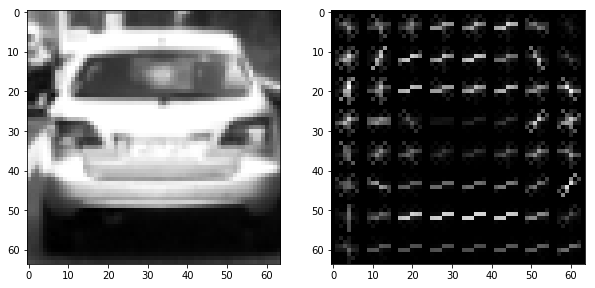

In [24]:
test_hog_features('./vehicles/KITTI_extracted', '31.png')

In [42]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [43]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [72]:
def extract_img_features(img_name, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2):
    img = mpimg.imread(img_name)
    img = img.astype(np.float32)  # png file has value between 0 and 1
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
        
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
    if hog_channel == -1:
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                 orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                        orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    features = np.concatenate((hist_features, spatial_features, hog_features))
        
    return features

In [76]:
def extract_features(img_list, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     hog_channel=0, orient=9, pix_per_cell=8, cell_per_block=2):
    features_ary = []
    for img_name in img_list:
        features = extract_img_features(img_name, cspace, spatial_size, hist_bins, hist_range,
                                       hog_channel, orient, pix_per_cell, cell_per_block)
        features_ary.append(features)
    return features_ary

In [49]:
import glob
def read_data(data_dir):
    data = []
    for dir, _ ,_ in os.walk(data_dir):
        data.extend(glob.glob(os.path.join(dir,'*.*')))
    return data

In [54]:
car_list = read_data('./vehicles')
nocar_list = read_data('./non-vehicles')
print(len(car_list), len(nocar_list))

8792 8968


In [57]:
features_extract_parameters = [['YCrCb', 'YUV', 'HLS', 'LUV', 'HSV', 'RGB'], [-1, 0, 1, 2]]

In [77]:
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def model(features_parameter):
    car_features = extract_features(car_list, features_parameter[0], spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                                    hog_channel=features_parameter[1], orient=9, pix_per_cell=8, cell_per_block=2)
    nocar_features = extract_features(nocar_list, features_parameter[0], spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                                      hog_channel=features_parameter[1], orient=9, pix_per_cell=8, cell_per_block=2)
    features = np.vstack([car_features, nocar_features]).astype(np.float64)
    scaler = StandardScaler().fit(features)
    X = scaler.transform(features)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocar_features))))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
    clf = LinearSVC(random_state=0)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    accuracy_train =  accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    beta = 0.5
    f_train = fbeta_score(y_train, y_train_pred, beta=beta)
    f_test = fbeta_score(y_test, y_test_pred, beta=beta)
    return accuracy_train, accuracy_test, f_train, f_test

In [ ]:
accuracy_train, accuracy_test, f_train, f_test = model(['YCrCb', -1])

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
